# Assessment for Advanced Data Science

## Christian Cabrera, Carl Henrik Ek and Neil D. Lawrence

### 29th October 2021



Welcome to the course assessment for the Advanced Data Science unit. In this assessment you will build a prediction system for UK house prices. 

Your prediction system will be based on data from the UK Price Paid data available [here](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). By combining this data with the UK Office for National Statistics data on the latitude/longitude of postcodes (available [here](https://www.getthedata.com/open-postcode-geo)) you will have a record of house prices and their approximate latitude/longitude. Due to the size of these data you will use a relational database to handle them.  

To make predictions of the house price you will augment your data with information obtained from Open Street Map: an open license source of mapping information. You will use the techniques you have learnt in the course to indentify and incorporate useful features for house price prediction.



Alongside your implementation you will provide a short repository overview describing how you have implemented the different parts of the project and where you have placed those parts in your code repository. You will submit your code alongside a version of this notebook that will allow your examiner to understand and reconstruct the thinking behind your analysis. This notebook is structured to help you in creating that description and allow you to understand how we will allocate the marks. You should make use of the Fynesse framework (<https://github.com/lawrennd/fynesse_template>) for structuring your code. 

Remember the notebook you create should *tell a story*, any code that is not critical to that story can safely be placed into the associated analysis library and imported for use (structured as given in the Fynesse template)

The maximum total mark for this assessment is 20. That mark is split into Three Questions below, each worth 5 marks each. Then a final 5 marks will be given for the quality, structure and reusability of the code and analysis you produce giving 20 marks in total.


### Useful Links

You may find some of the following links useful when building your system.

University instuctions on Security and Privacy with AWS.

https://help.uis.cam.ac.uk/service/network-services/hosting-services/AWS/aws-security-privacy

Security Rules in AWS 

https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/USER_VPC.Scenarios.html#USER_VPC.Scenario4

### Installing Your Library

One artefact to be included in your submission is a python library structured according to the "Access, Assess, Address" standard for data science solutions. You will submit this library alongside your code. Use the cell below to perform the necessary installation instructions for your library.

You should base your module on the template repository given by the Fynesse template repository. That should make it `pip` installable as below. 



In [1]:
# Install your library here, for example the fynesse template 
# is set up to be pip installable
%pip install git+https://github.com/slippedandmissed/ads-assessment.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/slippedandmissed/ads-assessment.git to /tmp/pip-req-build-37snq_wi
  Running command git clone --filter=blob:none -q https://github.com/slippedandmissed/ads-assessment.git /tmp/pip-req-build-37snq_wi
  Resolved https://github.com/slippedandmissed/ads-assessment.git to commit eb2e4b15c84f4e56fc40098d599b931a45501c6e
  Preparing metadata (setup.py) ... done
You should consider upgrading via the '/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Your own library should be installed in the line above, then you can import it as usual (where you can either replace `fynesse` with the name you've given your analysis module or you can leave the name as `fynesse` as you prefer).

In [2]:
from ads_assessment import *

## Question 1. Accessing a Database of House Prices, Latitudes and Longitudes

The UK price paid data for housing in dates back to 1995 and contains millions of transactions. The size of the data makes it unwieldy to manipulate directly in python frameworks such as `pandas`. As a result we will host the data in a *relational database*. 

Using the following ideas.

1. A cloud hosted database (such as MariaDB hosted on the AWS RDS service).
2. The SQL language wrapped in appropriately structured python code.
3. Joining of two databases.

You will construct a database containing tables that contain all house prices, latitudes and longitudes from the UK house price data base since 1995.

You will likely find the following resources helpful.

1. Lecture 1, 2 and 3.
2. Lab class 1 and 2.
3. The UK Price Paid data for houses: <https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads>
4. The UK ONS Data base of postcode latitude and longitudes:  <https://www.getthedata.com/open-postcode-geo>

Below we provide codeboxes and hints to help you develop your answer.

*The main knowledge you need to do a first pass through this question will have been taught by the end of Lab Session 2 (11th November 2021). You will likely want to review your answer as part of **refactoring** your code  and analysis pipeline shortly before hand in.*

*5 Marks*

### Task A

Set up the database. You'll need to set up a database on AWS. You were guided in how to do this in the lab sessions. You should be able to use the same database instance you created in the lab, or you can delete that and start with a fresh instance. You'll remember from the lab that the database requires credentials (username, password) to access. It's good practice to store those credentials *outside* the notebook so you don't accidentally share them by e.g. checking code into a repository. 
  
Call the database you use for this assessment `property_prices`.
  

In [3]:
# Write code for requesting and storing credentials (username, password) here.

config.load_config(".env")

In [4]:
# Write any other setup code you need for setting up database access here.

with access.make_connection(override_database_name="mysql") as conn:
  access.execute(conn, "CREATE DATABASE IF NOT EXISTS `property_prices` DEFAULT CHARACTER SET utf8 COLLATE utf8_bin;")


### Task B

Create a database table called `pp_data` containing all the UK Price Paid data from the [gov.uk site](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). You'll need to prepare a new table to receive the data and upload the UK Price Paid data to your database instance. The total data is over 3 gigabytes in size. We suggest that rather than downloading the full data in CSV format, you use the fact that they have split the data into years and into different parts per year. For example, the first part of the data for 2018 is stored at <http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018-part1.csv>. Each of these files is less than 100MB and can be downloaded very quickly to local disk, then uploaded using 


```
LOCAL DATA LOAD INFILE 'filename' INTO TABLE `table_name`
FIELDS TERMINATED BY ',' 
LINES STARTING BY '' TERMINATED BY '\n';
```
*Note* this command should be wrapped and placed in an appropriately structured python module. 

Each 'data part' should be downloadable from the `gov.uk` site and uploadable to your database instance in a couple of seconds. By looping across the years and different parts, you should be able to robustly upload this large data set to your database instance in a matter of minutes. 

You may find the following schema useful in creation of your database:

```
--
-- Table structure for table `pp_data`
--
DROP TABLE IF EXISTS `pp_data`;
CREATE TABLE IF NOT EXISTS `pp_data` (
  `transaction_unique_identifier` tinytext COLLATE utf8_bin NOT NULL,
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
  `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `primary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `secondary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `street` tinytext COLLATE utf8_bin NOT NULL,
  `locality` tinytext COLLATE utf8_bin NOT NULL,
  `town_city` tinytext COLLATE utf8_bin NOT NULL,
  `district` tinytext COLLATE utf8_bin NOT NULL,
  `county` tinytext COLLATE utf8_bin NOT NULL,
  `ppd_category_type` varchar(2) COLLATE utf8_bin NOT NULL,
  `record_status` varchar(2) COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;
```
This schema is written by Dale Potter and can be found on Github here: <https://github.com/dalepotter/uk_property_price_data/blob/master/create_db.sql>

You may also find it helpful to set up the following primary key in the database

```
--
-- Primary key for table `pp_data`
--
ALTER TABLE `pp_data`
ADD PRIMARY KEY (`db_id`);
MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;
```

In the box below, briefly describe what the schema is doing.

This schema contains data about property sales. It relates the price at which a property was sold to the location and date of sale. It does not contain geographical data such as GPS coordinates, but instead deals with administrative locations (address, post code, etc.). It also assigns a unique ID named `db_id` which increments from 1 with each row. This is used as the primary key for the table.


In [5]:
# Write the code you need for creating the database table and uploading the data here.

with access.make_connection(local_infile=True) as conn:
  # Create the table
  access.execute(conn, "DROP TABLE IF EXISTS `pp_data`;")
  access.execute(conn, """CREATE TABLE IF NOT EXISTS `pp_data` (
    `transaction_unique_identifier` tinytext COLLATE utf8_bin NOT NULL,
    `price` int(10) unsigned NOT NULL,
    `date_of_transfer` date NOT NULL,
    `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
    `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
    `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
    `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
    `primary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
    `secondary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
    `street` tinytext COLLATE utf8_bin NOT NULL,
    `locality` tinytext COLLATE utf8_bin NOT NULL,
    `town_city` tinytext COLLATE utf8_bin NOT NULL,
    `district` tinytext COLLATE utf8_bin NOT NULL,
    `county` tinytext COLLATE utf8_bin NOT NULL,
    `ppd_category_type` varchar(2) COLLATE utf8_bin NOT NULL,
    `record_status` varchar(2) COLLATE utf8_bin NOT NULL,
    `db_id` bigint(20) unsigned NOT NULL
  ) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;""")
  access.execute(conn, "ALTER TABLE `pp_data` ADD PRIMARY KEY (`db_id`);")
  access.execute(conn, "ALTER TABLE `pp_data` MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;")

  # Upload all of the data
  for year in range(1995, 2022):
    for part in [1,2]:
      access.upload_pp_data(conn, year, part)
  access.upload_pp_data(conn, 2022)


# Check that all of the data got uploaded successfully
# In particular, check that the number of uploaded records
# matches the number of rows in all the CSVs that got
# downloaded to ./pp_data
print("Expecting to find ", end="")
!echo -n $(expr $(wc -l ./pp_data/*.csv | tail -n1 | sed 's/[^0-9]//g') + $(ls -1 ./pp_data/*.csv | wc -l))
print(" records...")

with access.make_connection() as conn:
  num_records = access.query(conn, "SELECT COUNT(*) FROM `pp_data`")[0][0]
  print(f"Actually found {num_records} records!")

Downloaded ./pp_data/y1995-part1.csv
Downloaded ./pp_data/y1995-part2.csv
Downloaded ./pp_data/y1996-part1.csv
Downloaded ./pp_data/y1996-part2.csv
Downloaded ./pp_data/y1997-part1.csv
Downloaded ./pp_data/y1997-part2.csv
Downloaded ./pp_data/y1998-part1.csv
Downloaded ./pp_data/y1998-part2.csv
Downloaded ./pp_data/y1999-part1.csv
Downloaded ./pp_data/y1999-part2.csv
Downloaded ./pp_data/y2000-part1.csv
Downloaded ./pp_data/y2000-part2.csv
Downloaded ./pp_data/y2001-part1.csv
Downloaded ./pp_data/y2001-part2.csv
Downloaded ./pp_data/y2002-part1.csv
Downloaded ./pp_data/y2002-part2.csv
Downloaded ./pp_data/y2003-part1.csv
Downloaded ./pp_data/y2003-part2.csv
Downloaded ./pp_data/y2004-part1.csv
Downloaded ./pp_data/y2004-part2.csv
Downloaded ./pp_data/y2005-part1.csv
Downloaded ./pp_data/y2005-part2.csv
Downloaded ./pp_data/y2006-part1.csv
Downloaded ./pp_data/y2006-part2.csv
Downloaded ./pp_data/y2007-part1.csv
Downloaded ./pp_data/y2007-part2.csv
Downloaded ./pp_data/y2008-part1.csv
D

### Task C

Create a database table called `postcode_data` containing the ONS Postcode information. <GetTheData.com> has organised data derived from the UK Office for National Statistics into a convenient CSV file. You can find details [here](https://www.getthedata.com/open-postcode-geo).


The data you need can be found at this url: <https://www.getthedata.com/downloads/open_postcode_geo.csv.zip>. It will need to be unzipped before use.

You may find the following schema useful for the postcode data (developed by Christian and Neil)

```
USE `property_prices`;
--
-- Table structure for table `postcode_data`
--
DROP TABLE IF EXISTS `postcode_data`;
CREATE TABLE IF NOT EXISTS `postcode_data` (
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `status` enum('live','terminated') NOT NULL,
  `usertype` enum('small', 'large') NOT NULL,
  `easting` int unsigned,
  `northing` int unsigned,
  `positional_quality_indicator` int NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `lattitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `postcode_no_space` tinytext COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_seven` varchar(7) COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_eight` varchar(8) COLLATE utf8_bin NOT NULL,
  `postcode_area` varchar(2) COLLATE utf8_bin NOT NULL,
  `postcode_district` varchar(4) COLLATE utf8_bin NOT NULL,
  `postcode_sector` varchar(6) COLLATE utf8_bin NOT NULL,
  `outcode` varchar(4) COLLATE utf8_bin NOT NULL,
  `incode` varchar(3)  COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin;
```

And you can load the CSV file into the table in one "INFILE".

```
LOAD DATA LOCAL INFILE 'open_postcode_geo.csv' INTO TABLE `postcode_data`
FIELDS TERMINATED BY ',' 
LINES STARTING BY '' TERMINATED BY '\n';
```

In [6]:
import zipfile
import os

with access.make_connection(local_infile=True) as conn:
  access.execute(conn, "DROP TABLE IF EXISTS `postcode_data`;")
  access.execute(conn, """CREATE TABLE IF NOT EXISTS `postcode_data` (
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `status` enum('live','terminated') NOT NULL,
  `usertype` enum('small', 'large') NOT NULL,
  `easting` int unsigned,
  `northing` int unsigned,
  `positional_quality_indicator` int NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `lattitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `postcode_no_space` tinytext COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_seven` varchar(7) COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_eight` varchar(8) COLLATE utf8_bin NOT NULL,
  `postcode_area` varchar(2) COLLATE utf8_bin NOT NULL,
  `postcode_district` varchar(4) COLLATE utf8_bin NOT NULL,
  `postcode_sector` varchar(6) COLLATE utf8_bin NOT NULL,
  `outcode` varchar(4) COLLATE utf8_bin NOT NULL,
  `incode` varchar(3)  COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin;""")
  access.execute(conn, "ALTER TABLE `postcode_data` ADD PRIMARY KEY (`db_id`);")
  access.execute(conn, "ALTER TABLE `postcode_data` MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;")
  access.execute(conn, "CREATE INDEX idx_postcode_2 ON `postcode_data` (`postcode`);")
  access.execute(conn, "CREATE INDEX idx_lattitude ON `postcode_data` (`lattitude`);")
  access.execute(conn, "CREATE INDEX idx_longitude ON `postcode_data` (`longitude`);")

  postcode_data_dir = "postcode_data"
  zip_path = os.path.join(postcode_data_dir, "open_postcode_geo.csv.zip")
  csv_path = os.path.join(postcode_data_dir, "open_postcode_geo.csv")
  
  access.download_file("https://www.getthedata.com/downloads/open_postcode_geo.csv.zip", zip_path)
  with zipfile.ZipFile(zip_path, "r") as zfp:
    zfp.extractall(postcode_data_dir)

  access.upload_file(conn, "postcode_data", csv_path)

Downloaded postcode_data/open_postcode_geo.csv.zip


### Task D 

These data can now be joined to form a new table that contains house price paid and latitude longitude of the house. We could create a new table that contains all this information. However, the computation of that table will take some time because of the size of the two existing tables in the join. 

Instead, we're going to exploit the nature of the task. To build our prediction model, we're going to use the prices for a particular region in a given time period. This means we can select that region and time period and build the joined data only from the relevent rows from the two tables. This will save time on the join.

Whether this is a good idea or not in a live system will depend on how often these predictions are required. If it's very often, it would likely be better to store the entired database joined, because the one-off cost for that join is amortised across all the future predictions. If only a few predictions are required (like in our lab class) then doing that join on the fly might be better. In that case you can make use of an  *inner join* for this data set creation.

```
USE `property_prices`;
--
-- Table structure for table `prices_coordinates_data`
--
DROP TABLE IF EXISTS `prices_coordinates_data`;
CREATE TABLE IF NOT EXISTS `prices_coordinates_data` (
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
  `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `locality` tinytext COLLATE utf8_bin NOT NULL,
  `town_city` tinytext COLLATE utf8_bin NOT NULL,
  `district` tinytext COLLATE utf8_bin NOT NULL,
  `county` tinytext COLLATE utf8_bin NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `lattitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;


```



## Question 2. Accessing OpenStreetMap and Assessing the Available Features

In question 3 you will be given the task of constructing a prediction system for property price levels at a given location. We expect that knowledge of the local region around the property should be helpful in making those price predictions. To evaluate this we will now look at [OpenStreetMap](https://www.openstreetmap.org) as a data source.

The tasks below will guide you in accessing and assessing the OpenStreetMap data. The code you write will eventually be assimilated in your python module, but documentation of what you've included and why should remain in the notebook below. 

Accessing OpenStreetMap through its API can be done using the python library `osmx`. Using what you have learned about the `osmx` interface in the lectures, write general code for downloading points of interest and other relevant information that you believe may be useful for predicting house prices. Remembering the perspectives we've taken on *data science as debugging*, the remarks we've made when discussing *the data crisis* of the importance of reusability in data analysis, and the techniques we've explored in the labsessions for visualising features and exploring their correlation use the notebook to document your assessment of the OpenStreetMap data as a potential source of data.

The knowledge you need to do a first pass through this question will have been taught by end of lab session three (16th November 2021). You will likely want to review your answer as part of *refactoring* your code and analysis pipeline shortly before hand in.

You should write reusable code that allows you to explore the characteristics of different points of interest. Looking ahead to question 3 you'll want to incorporate these points of interest in your prediction code.

*5 marks*


My proposed model for estimating the price at which a property sold includes (as suggested in Question 3) selecting an appropriately large region and time period around the given property from which to collect training data. I would like to make sure that the region I select will contain enough data. In particular, I would like to know for a given region size and time period size, that such a range is likely to contain enough data points (property sales).

While having a larger region and time period would provide more data points from which to train, it does bring about two major disadvantages.
 - A larger region and time period is likely to make the relationships between the indicator and response variables more complicated, making them harder to learn
 - A larger region means that the calls to the OpenStreetMap API take considerably longer, and a larger time period means that more of those calls have to be made (1 per day in the range).

This is why it is important to strike a balance of region and time period size rather than simply using massive ones &mdash; the two bottlenecks above present issues long before local memory usage does.

Ideally I would like to have at least 125 data points for a given region/time period, so that 20% of them can be used as validation data leaving at least 100 data points to fit the model. Unfortunately, in order to get a 95% chance that a given region/time period contains at least 125 data points, the region would need to be 250km $\times$ 250km and 7 days wide, which makes the predictions take far too long to compute (the bottleneck being the calls to the OSM API). Even a region of size 100km $\times$ 100km (about a 60% chance of having at least 125 data points) takes about 3 hours to compute a prediction on my machine. Due to this time limitation, I will use a region of 10km $\times$ 10km, which on average contains about 110 data points, with a 40% chance of having fewer than 38 (which, with 20% validation data leaves fewer than 30 for training).

All of these values were calculated using the code below, tweaking the parameters.

I first select a sample of $n=50$ random location datapoints from the dataset, each with a random associated date from within the dataset. For each of them, I find the number of data points in the surrounding region/time period.

In [7]:
# Use this cell and cells below for summarising your analysis and documenting your decision making.
import numpy as np
from datetime import datetime, date, timedelta

n = 50
random_coords = assess.get_random_coords_in_dataset(n)

start_date = date(1996, 1, 1)
end_date = date(2022, 1, 1)
random_date_offsets = np.random.randint(0, (end_date-start_date).days, size=(n,))
random_dates = list(start_date + timedelta(days=int(t)) for t in random_date_offsets)

print(random_dates[:5])
random_coords.head()

[datetime.date(2008, 8, 8), datetime.date(2000, 1, 23), datetime.date(1996, 5, 6), datetime.date(2007, 2, 21), datetime.date(1998, 11, 28)]


,Lattitude,Longitude
0,53.63302400,-2.33533400
1,51.12587200,-0.00974300
2,51.59652800,-1.86511300
3,52.96681200,-1.10221800
4,51.71274700,0.55627100


Ideally, I would have liked to use $n>>50$ but sampling each (as below) takes ~90 seconds, so $n=50$ already takes ~75 minutes. The bottleneck for this stage comes from performing the inner join described in Question 1.D

In [8]:
from tqdm import tqdm

proposed_box_size_km = 10   # This is like a "radius" of the region, with the diameter being double this value.
proposed_box_size_days = 3  # Likewise, this is the number of days plus or minus the central date.

boxes = []
num_properties = []
pp_and_postcode_datas = []

with access.make_connection() as conn:
  for idx, row in tqdm(random_coords.iterrows(), total=n, leave=False):
    lat, lng = float(row["Lattitude"]), float(row["Longitude"])
    
    box = assess.calculate_box(
      lat,
      lng,
      proposed_box_size_km,
      random_dates[idx],
      proposed_box_size_days
    )

    access.join_pp_and_postcode_data(conn, box)
    pp_and_postcode_data = access.fetch_pp_and_postcode_data(conn)

    boxes.append(box)
    pp_and_postcode_datas.append(pp_and_postcode_data)
    num_properties.append(len(pp_and_postcode_data))

num_properties = np.array(num_properties, dtype=int)

We can plot a histogram showing the distribution of the number of properties in a region of the given size over our sample.

I was expecting this to be a Poisson distribution, but the mean and the variance are significantly different. This is the case for the many different sizes of region and time period I have tried.

In [11]:
μ = np.mean(num_properties)
σ2 = np.var(num_properties)

print(μ)
print(σ2)

110.54
17172.288399999998


Perhaps unexpectedly, the shape of the distribution seems to vary dramatically depending on the chosen size of the region and time period. Sometimes it looks like a geometric distribution (often for smaller regions), and sometimes uniform (often for larger regions).

As such, I will just use the empirical distribution of the data.

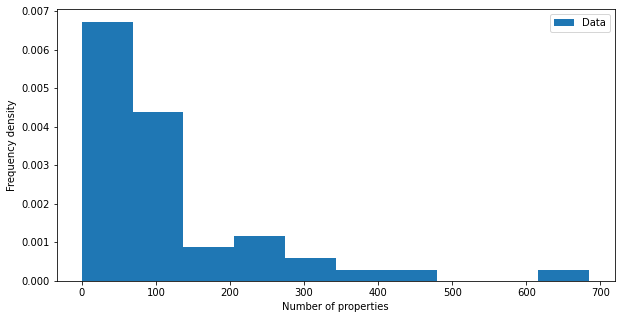

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(num_properties, density=True, label="Data")

ax.set_xlabel("Number of properties")
ax.set_ylabel("Frequency density")
ax.legend();

The cell below calculates the probability that a region of the given size over a given time period contains at least 38 data points (which, using 20% as validation data, leaves at least 30 for training data), according to the empirical distribution above.

In [10]:
np.mean(num_properties >= 38)

0.6

Analysis of the correlation between the distance from the property to the nearest city centre and the price.

What we find is a very noisy correlation between the distance to the nearest city centre and the log of the price. This noise is to be expected because of the myriad other factors which inform the price. Interestingly, the direction of the correlation seems to depend on the specific region being sampled. My interpretation of this fact is as evidence that there is some benefit to fitting a model on a region around the target point, rather than on the entire dataset, as there are some localised trends that do not generalise well outside of a small region. Attempting to learn from all of these regions at once may lead to a Simpson's Paradox.

The fact that some of these plots are empty corresponds to the fact that some of these sample regions contain no data points. This is an unfortunate consequence of the aforementioned tradeoff between speed and region size.

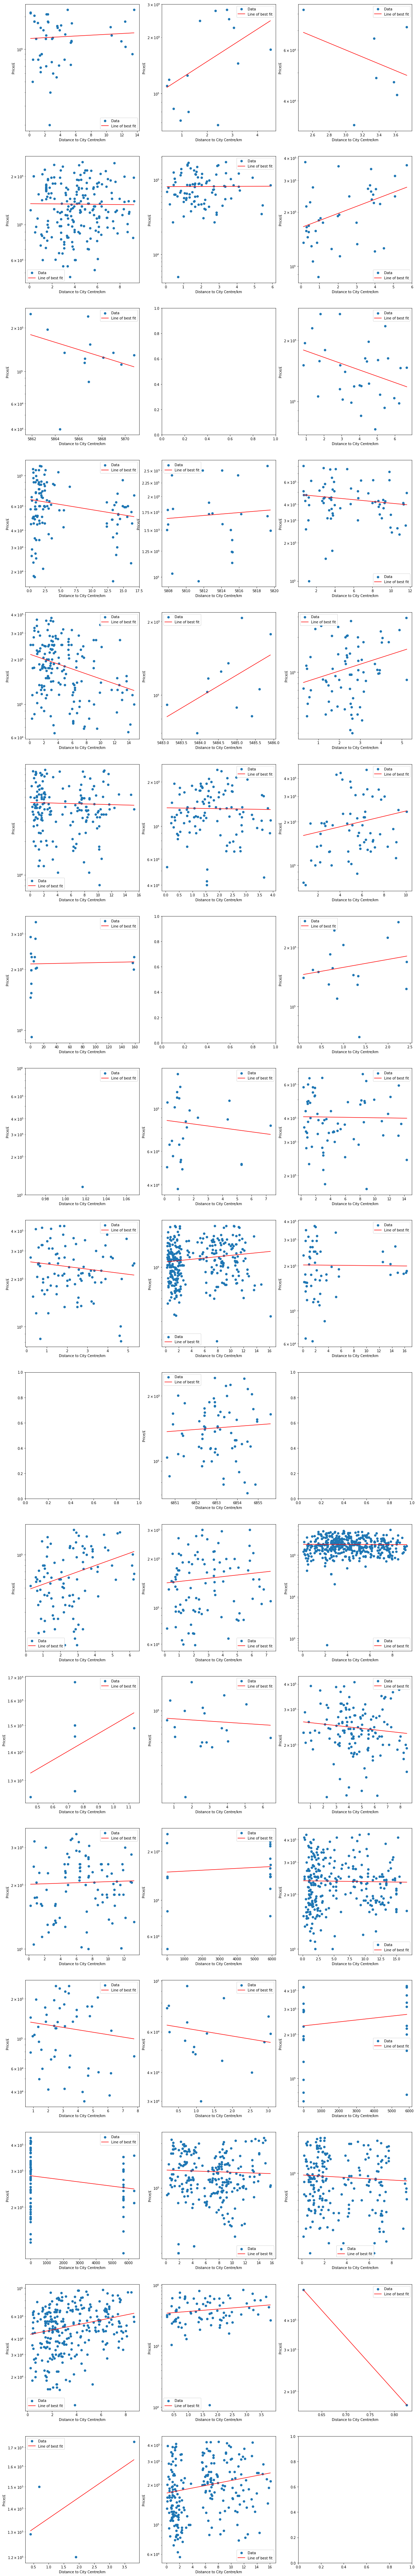

In [13]:
from tqdm import tqdm
import numpy as np
import warnings

cols = 3
rows = int(np.ceil(n/cols))
fig, axs = plt.subplots(rows, cols, figsize=(20, 8*rows))

for i, df in tqdm(enumerate(pp_and_postcode_datas), total=n, leave=False):
  box = boxes[i]
  df = assess.add_distance_to_city_data(df)
  ax = axs[i//cols, i%cols]

  x = df["Distance to City Center"].to_numpy()
  y = df["Price"].to_numpy()

  if len(x) == 0:
    continue
  
  # Discard outliers from the dataset.
  # This is mostly to make the graphs clearer
  # as otherwise the data tends to clump up
  # around the left-hand-side of the graph,
  # as the x-axis scale is too large so as
  # to accommodate the outliers.
  x_q1 = np.quantile(x, 0.25)
  x_q2 = np.quantile(x, 0.5)
  x_q3 = np.quantile(x, 0.75)
  x_iqr = x_q3 - x_q1
  x_lo = x_q2 - 1.5 * x_iqr
  x_hi = x_q2 + 1.5 * x_iqr

  y_q1 = np.quantile(y, 0.25)
  y_q2 = np.quantile(y, 0.5)
  y_q3 = np.quantile(y, 0.75)
  y_iqr = y_q3 - y_q1
  y_lo = y_q2 - 1.5 * y_iqr
  y_hi = y_q2 + 1.5 * y_iqr


  non_outliers = (x >= x_lo) & (x <= x_hi) & (y >= y_lo) & (y <= y_hi)

  x = x[non_outliers]
  y = y[non_outliers]

  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    a, b = np.polyfit(x, y, 1)
  z = np.linspace(np.min(x), np.max(x), 2)

  ax.scatter(x, y, label="Data")
  ax.plot(z, z*a+b, c="red", label="Line of best fit")

  ax.set_xlabel("Distance to City Centre/km")
  ax.set_ylabel("Price/£")

  ax.set_yscale("log")
  ax.legend()


I also want to visualise the relationships between several potential indicator variables and the price, to see if there is any correlation.

Below is an exploration of certain POIs within a certain radius of each property.

In [14]:
from pprint import pprint
# I have selected these tags because they are the ones
# I found which by inspection seem to have the strongest
# correlation with price.
#
# I have experimented with others such as:
#    - hospital
#    - restaurant
#    - public_transport
#    - amenity
#
# Unfortunately, the more features we include here, the
# longer the calls to OSM take, so when making the final
# prediction I have found that we can only include at
# most 4 tags. Any more than that and the prediction time
# takes much longer than 20 minutes
#
# The tags which performed best (resulted in highest confidence)
# became the default tags for address.predict_price
tags = {
  "cuisine": True,
  "shop": True,
  "tourism": True,
  "healthcare": True,
}

# Since the prediction process is so slow, it didn't make
# sense to automate a lot of trials, so I've used the code
# below to manually test several regions in the sample and
# draw conclusions based on the small amount of data I was
# able to collect.
i = 0
lat, lng = float(random_coords["Lattitude"][i]), float(random_coords["Longitude"][i])
date = random_dates[i]
property_type = "F"

prediction = address.predict_price(lat, lng, date, property_type, tags=tags)

pprint(prediction)

Joining property price and postcode data...
Joined.
Fetching joined data...
Fetched.
Fetching POIs...


Fetched.


{'confidence': 0.26666666666666666,
 'estimate': 135627.36027762832,
 'lower_bound': 90809.22803256556,
 'upper_bound': 202565.10548995028}


## Question 3. Addressing a Property Price Prediction Question

For your final tick, we will be asking you to make house price predictions for a given location, date and property type in the UK. You will provide a function that takes input a latitude and longitude as well as the `property_type` (either type" of property (either `F` - flat, `S` - semidetached, `D` - detached, `T` - terraced or `O` other). Create this function in the `address.py` file, for example in the form,

```
def predict_price(latitude, longitude, date, property_type):
    """Price prediction for UK housing."""
    pass
```

We suggest that you use the following approach when building your prediction. 

1. Select a bounding box around the housing location in latitude and longitude.
2. Select a data range around the prediction date. 
3. Use the data ecosystem you have build above to build a training set from the relevant time period and location in the UK. Include appropriate features from OSM to improve the prediction.
4. Train a linear model on the data set you have created.
5. Validate the quality of the model.
6. Provide a prediction of the price from the model, warning appropriately if your validation indicates the quality of the model is poor.

The knowledge you need to do a first pass through this question will have been taught by end of lab session four (25th November 2021). You will likely want to review your answer as part of *refactoring* your code shortly before hand in.

